In [14]:
%pip install -q -U "jax[cuda12]" blackjax arviz optax scikit-learn

In [15]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

dataset = load_breast_cancer(as_frame=False)
features, labels = dataset.data, dataset.target.astype(np.float32)

x_train_np, x_test_np, y_train_np, y_test_np = train_test_split(
    features,
    labels,
    test_size=0.2,
    random_state=0,
    stratify=labels,
)

scaler = StandardScaler()
x_train_np = scaler.fit_transform(x_train_np)
x_test_np = scaler.transform(x_test_np)

In [16]:
import jax
import jax.numpy as jnp

train_features = jnp.asarray(x_train_np)
train_labels = jnp.asarray(y_train_np)
test_features = jnp.asarray(x_test_np)
test_labels = jnp.asarray(y_test_np)

In [17]:
jax.device_count()

1

In [18]:
jax.default_backend()

'gpu'

In [19]:
def logistic_regression_logprob(theta, x, y):
    weight, bias = theta[:-1], theta[-1]
    logits = jnp.dot(x, weight) + bias
    log_likelihood = jnp.sum(y * logits - jnp.logaddexp(0.0, logits))
    log_prior = -0.5 * jnp.sum(theta**2)  # standard normal prior
    return log_likelihood + log_prior

In [20]:
from functools import partial

target_logprob = partial(logistic_regression_logprob, x=train_features, y=train_labels)

In [21]:
import blackjax

num_integration_steps = 10
dimension = train_features.shape[1] + 1

def build_hmc(step_size, inverse_mass_matrix):
    return blackjax.hmc(
        logdensity_fn=target_logprob,
        step_size=step_size,
        inverse_mass_matrix=inverse_mass_matrix,
        num_integration_steps=num_integration_steps,
    )

step_size = 1e-2
inverse_mass_matrix = jnp.ones(dimension)
hmc = build_hmc(step_size, inverse_mass_matrix)
init_state = hmc.init(jnp.zeros(dimension))

In [22]:
def sample_hmc(hmc, rng_key, state, num_samples):
    def one_step(carry, _):
        rng_key, state = carry
        rng_key, subkey = jax.random.split(rng_key)
        state, info = hmc.step(subkey, state)
        return (rng_key, state), (state.position, info)

    (_, final_state), (positions, infos) = jax.lax.scan(
        one_step, (rng_key, state), xs=None, length=num_samples
    )
    return positions, infos, final_state

In [23]:
def tune_hmc(rng_key, state, step_size, inverse_mass_matrix, num_rounds=6, batch_size=256):
    log_history = []
    for round_id in range(num_rounds):
        hmc = build_hmc(step_size, inverse_mass_matrix)
        rng_key, round_key = jax.random.split(rng_key)
        positions, infos, state = sample_hmc(hmc, round_key, state, num_samples=batch_size)
        accept_rate = float(jnp.mean(infos.is_accepted))

        if accept_rate < 0.75:
            step_size *= 0.8
        elif accept_rate > 0.85:
            step_size *= 1.2

        centered = positions - jnp.mean(positions, axis=0)
        variances = jnp.mean(centered**2, axis=0) + 1e-3
        inverse_mass_matrix = 1.0 / variances

        log_history.append((round_id, accept_rate, step_size))

    final_hmc = build_hmc(step_size, inverse_mass_matrix)
    return final_hmc, state, inverse_mass_matrix, log_history, rng_key

rng_key = jax.random.key(0)
hmc, state, inverse_mass_matrix, warmup_log, rng_key = tune_hmc(
    rng_key,
    init_state,
    step_size=step_size,
    inverse_mass_matrix=inverse_mass_matrix,
)

rng_key, draw_key = jax.random.split(rng_key)
positions, infos, state = sample_hmc(hmc, draw_key, state, num_samples=2000)
posterior_draws = positions

In [24]:
chain_ids = jnp.arange(4)
chain_keys = jax.random.split(rng_key, len(chain_ids))
chain_positions = state.position + 0.01 * jax.vmap(
    lambda key: jax.random.normal(key, state.position.shape)
)(chain_keys)

@jax.vmap
def run_chain(rng_key, initial_position):
    state = hmc.init(initial_position)
    samples, infos, _ = sample_hmc(hmc, rng_key, state, num_samples=1000)
    return samples, infos

samples, infos = run_chain(chain_keys, chain_positions)
posterior_draws = samples.reshape(-1, dimension)

In [25]:
import arviz as az

# Use the samples with chain structure directly
idata = az.from_dict(
    posterior={"theta": samples},
    sample_stats={
        "accept_prob": infos.is_accepted,
        "energy": infos.energy,
    },
    dims={"theta": ["theta_dim"]}, # Optional: provide dimension names
)

# Use kind="diagnostics" to get convergence diagnostics
summary = az.summary(idata, var_names=["theta"], kind="diagnostics")
print(summary[["ess_bulk", "r_hat"]])

# You can also get the stats summary separately if needed
stats_summary = az.summary(idata, var_names=["theta"], kind="stats")
print("\nStats Summary:")
print(stats_summary[["mean", "sd", "hdi_3%", "hdi_97%"]])

           ess_bulk  r_hat
theta[0]      152.0   1.03
theta[1]      616.0   1.01
theta[2]      291.0   1.01
theta[3]       76.0   1.09
theta[4]      383.0   1.00
theta[5]      271.0   1.01
theta[6]      358.0   1.02
theta[7]      171.0   1.01
theta[8]      872.0   1.00
theta[9]      244.0   1.01
theta[10]     114.0   1.00
theta[11]     690.0   1.01
theta[12]     178.0   1.01
theta[13]      90.0   1.03
theta[14]     853.0   1.00
theta[15]     384.0   1.01
theta[16]     339.0   1.02
theta[17]     392.0   1.01
theta[18]     549.0   1.00
theta[19]     255.0   1.01
theta[20]      56.0   1.06
theta[21]     477.0   1.02
theta[22]     183.0   1.01
theta[23]     115.0   1.03
theta[24]     421.0   1.00
theta[25]     252.0   1.01
theta[26]     234.0   1.02
theta[27]     237.0   1.01
theta[28]     629.0   1.00
theta[29]     209.0   1.01
theta[30]     557.0   1.00

Stats Summary:
            mean     sd  hdi_3%  hdi_97%
theta[0]  -0.661  0.919  -2.440    0.975
theta[1]  -0.579  0.590  -1.618    0.5

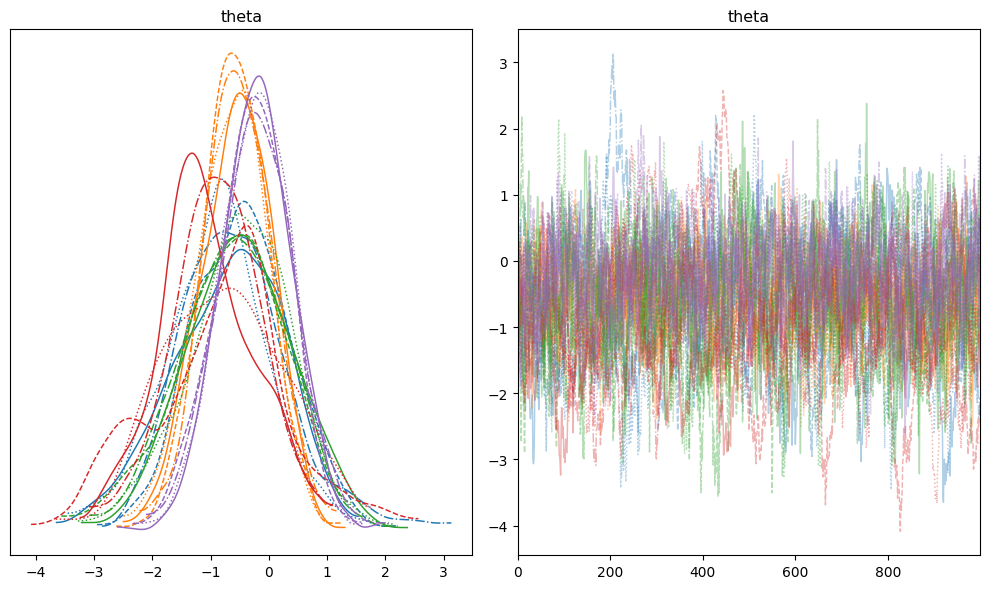

In [26]:
import matplotlib.pyplot as plt

az.plot_trace(
    idata,
    var_names=["theta"],
    coords={"theta_dim": slice(0, 4)},
    compact=True,
    figsize=(10, 6),
)
plt.tight_layout()

In [27]:
def posterior_predictive_mean(theta_samples, x):
    logits = x @ theta_samples[..., :-1].T + theta_samples[..., -1]
    mean_logit = jnp.mean(logits, axis=-1)
    return jax.nn.sigmoid(mean_logit)

theta_samples = posterior_draws.reshape(-1, train_features.shape[1] + 1)
probs = posterior_predictive_mean(theta_samples, test_features)
pred_labels = (probs > 0.5).astype(jnp.int32)
test_accuracy = jnp.mean(pred_labels == test_labels)
print(f"Posterior predictive accuracy: {test_accuracy * 100:.1f}%")

Posterior predictive accuracy: 98.2%
